In [1]:
%load_ext autoreload
%autoreload 2
    
import os
import sys
import time
import glob
import gc

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, random
import optax

%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Times'

sys.path.insert(0, os.path.abspath(os.path.join('../')))

In [2]:
from geometric_bayesian.utils.types import Size
from flax import nnx

class SimpleModel(nnx.Module):
    def __init__(self, rngs):
        self.layer = nnx.Linear(2, 1, rngs=rngs, use_bias=False)

    def __call__(self, x: jax.Array):
        return nnx.sigmoid(self.layer(x)).squeeze()

    @property
    def shape(self) -> Size:
        return jnp.array([2, 1])

In [3]:
model = SimpleModel(nnx.Rngs(params=0))

In [4]:
x_1 = jax.random.multivariate_normal(jax.random.key(0), jnp.array([-1,-1]), 0.2*jnp.eye(2), shape=(100,))
y_1 = jnp.zeros(100)
x_2 = jax.random.multivariate_normal(jax.random.key(0), jnp.array([1,1]), 0.2*jnp.eye(2), shape=(100,))
y_2 = jnp.ones(100)

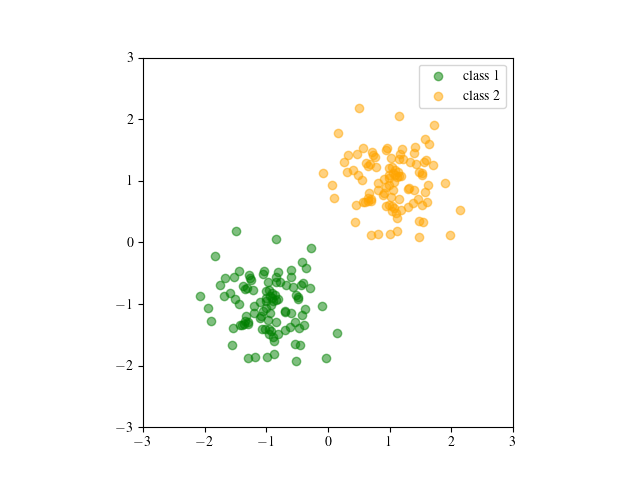

In [5]:
fig, ax = plt.subplots()
# pred = model(X_test)
ax.scatter(x_1[:,0], x_1[:,1], label='class 1', color='green', alpha=0.5)
ax.scatter(x_2[:,0], x_2[:,1], label='class 2', color='orange', alpha=0.5)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
ax.set_aspect('equal', 'box')
ax.legend()

In [6]:
from geometric_bayesian.utils import DataLoader
X = jnp.concatenate((x_1,x_2), axis=0)
y = jnp.concatenate((y_1,y_2))

In [7]:
n_epochs = 300
step_size = 1e-2
optimizer = nnx.Optimizer(model, optax.adam(step_size))

def criterion(y, y_pred):
    return -jnp.sum(y*jnp.log(y_pred) + (1-y)*jnp.log(1-y_pred))

train_loader = DataLoader(X, y, 30, shuffle=True)

@nnx.jit
def train_step(model, optimizer, x, y):
    def loss_fn(model: SimpleModel):
        y_pred = model(x)
        return criterion(y, y_pred)

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads) 

    return loss

In [8]:
losses = []
for epoch in range(n_epochs):
    for x_tr, y_tr in train_loader:
        losses.append(train_step(model, optimizer, x_tr, y_tr))

    if epoch % 100 == 0:
        print(f"[epoch {epoch}]: loss: {losses[-1]:.4f}")

print(f'{optimizer.step.value = }')
print(f"Final loss: {losses[-1]:.4f}")

[epoch 0]: loss: 12.6620
[epoch 100]: loss: 0.6789
[epoch 200]: loss: 0.2313
optimizer.step.value = Array(2100, dtype=uint32)
Final loss: 0.1456


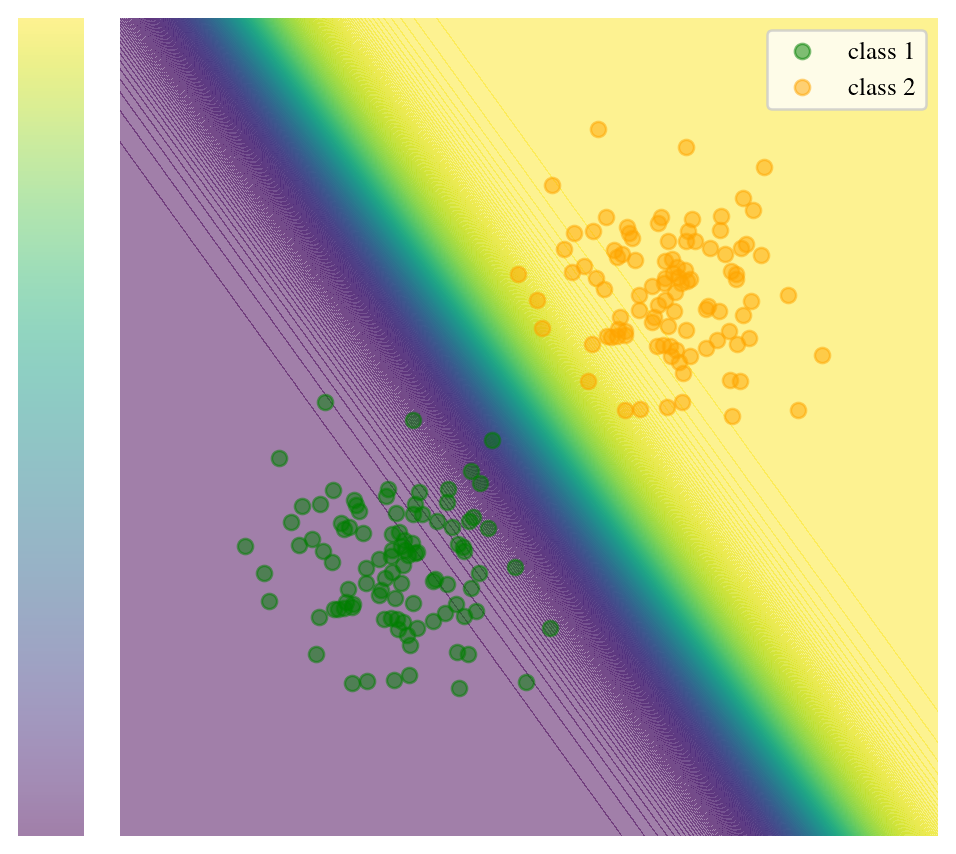

In [9]:
from geometric_bayesian.utils.plotting import contour_plot
contour_plot(model, min=[-3, -3], max=[3, 3], res=100, iso=False, alpha=0.5, zorder=-1, fig=fig)

In [10]:
from functools import partial
from geometric_bayesian.densities.bernoulli import Bernoulli

p_ll = lambda f : Bernoulli(f)

@partial(jax.custom_jvp, nondiff_argnums=(0,1))
def neg_logll(p, y, f):
    return jax.vmap(lambda y, f: -p(f)._logpdf(y), in_axes=(0,0))(y,f).sum()

@neg_logll.defjvp
@partial(jax.custom_jvp, nondiff_argnums=(0,1,3))
def neg_logll_jvp(p, y, primals, tangents):
    f = primals[0]
    v = tangents[0]
    print("hello")
    return neg_logll(p, y, f), jax.vmap(lambda y, f, v: -p(f)._logpdf_jvp_mean(y, v), in_axes=(0,0,0))(y,f,v)

@neg_logll_jvp.defjvp
def neg_logll_hvp(p, y, primals, tangents):
    f = primals[0]
    v = tangents[0]
    return neg_logll(p, y, f), jax.vmap(lambda y, f, v: -p(f)._logpdf_hvp_mean(y, v), in_axes=(0,0,0))(y,f,v)

In [11]:
from geometric_bayesian.densities.multivariate_normal import MultivariateNormal
from geometric_bayesian.operators.diag_operator import DiagOperator
from geometric_bayesian.utils.jax import pytree_to_array, array_to_pytree
from geometric_bayesian.utils.types import PyTree, Matrix

graph_def, map_params = nnx.split(model)
def model_fn(input, params):
    return nnx.call((graph_def, params))(input)[0]
num_params = sum(x.size for x in jax.tree.leaves(map_params))

p_prior = MultivariateNormal(jnp.zeros(num_params), DiagOperator(1.0, num_params))

def loss(params):
    if isinstance(params, Matrix):
        return jax.vmap(lambda params: neg_logll(p_ll, y, model_fn(X, array_to_pytree(params, map_params))) - p_prior._logpdf(params))(params)
    else:
        return neg_logll(p_ll, y, model_fn(X, array_to_pytree(params, map_params))) - p_prior._logpdf(params)

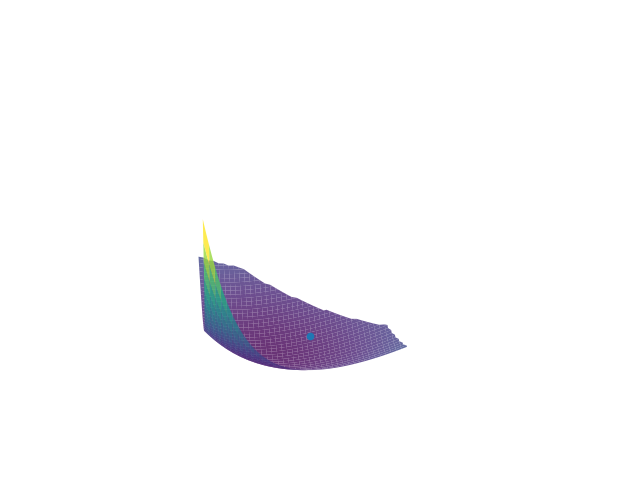

In [15]:
from geometric_bayesian.utils.plotting import surf_plot
fig = surf_plot(loss, min=[0, 0], max=[10, 10], res=100, fig=None)
ax = fig.axes[0]

map_p = pytree_to_array(map_params)
ax.scatter(map_p[0], map_p[1], loss(map_p))

In [13]:
pytree_to_array(map_params)

Array([4.172973, 3.01698 ], dtype=float32)